In [1]:
import requests
from io import StringIO
import pandas as pd
import numpy as np
import sqlite3
sqlite3.register_adapter(np.int64, int)
import re
import math
from datetime import date
import matplotlib.pyplot as plt

# 展開所有dataframe columns
pd.set_option('display.max_rows', 2000)
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

# 不縮寫成科學記號
pd.set_option('display.float_format',lambda x : '%.2f' % x)

db = sqlite3.connect('../stock.db' , isolation_level=None)

In [2]:
# 下次換季時間： 8/14, 11/14, 3/31, 5/15
QUARTERS = ['2022q2','2022q3','2022q4','2023q1']
CURRENT_QUARTER = QUARTERS[-1][-2:]
CURRENT_QUARTERS = list(map(lambda q: q[-2:], QUARTERS))
CURRENT_YEAR = int(QUARTERS[-1][0:4])
LAST_YEAR_QUARTER = '2022q4'
print("QUARTERS:", QUARTERS)
print("CURRENT_QUARTER:", CURRENT_QUARTER)
print("CURRENT_QUARTERS:", CURRENT_QUARTERS)
print("CURRENT_YEAR:", CURRENT_YEAR)
print("LAST_YEAR_QUARTER:", LAST_YEAR_QUARTER)

QUARTERS: ['2022q2', '2022q3', '2022q4', '2023q1']
CURRENT_QUARTER: q1
CURRENT_QUARTERS: ['q2', 'q3', 'q4', 'q1']
CURRENT_YEAR: 2023
LAST_YEAR_QUARTER: 2022q4


In [3]:
# 查詢股本table
df_stock_id_name = pd.read_sql_query("select * from stockIdName",db)
df_stock_id_name.head()

,id,name,listingDate,market,industry,capital
0,1101,台泥,1962/02/09,上市,水泥工業,69.37
1,1102,亞泥,1962/06/08,上市,水泥工業,35.46
2,1103,嘉泥,1969/11/14,上市,水泥工業,7.75
3,1104,環泥,1971/02/01,上市,水泥工業,6.54
4,1108,幸福,1990/06/06,上市,水泥工業,4.05


In [4]:
out = df_stock_id_name[['id', 'name', 'industry', 'capital']]
out.head()

,id,name,industry,capital
0,1101,台泥,水泥工業,69.37
1,1102,亞泥,水泥工業,35.46
2,1103,嘉泥,水泥工業,7.75
3,1104,環泥,水泥工業,6.54
4,1108,幸福,水泥工業,4.05


In [5]:
ids = out['id'].tolist()

# 用的到的table(加速運算時間,不用每個id都查db)

In [6]:
monthly = pd.read_sql_query(f"select * from monthlyRevenue order by date" , db)
daily = pd.read_sql_query("select * from daily",db)
daily = daily.sort_values(by=['date'])
cashflow = pd.read_sql_query("select * from cashflow",db)
# 財報
df_financial_statement = pd.read_sql_query("select * from financialStatement",db)
df_financial_statement = df_financial_statement.fillna(0)
df_financial_statement.replace('--', 0, inplace=True)

# YoY > 0筆數

月營收yoy>0筆數

In [7]:
def countYoYGreaterThan0(id):
    sql=f"select * from monthlyRevenue where id={id}" 
    df = pd.read_sql_query(sql, db)
    
    try:
        filter = len(df[df['YoY'] > 0])
        return filter
    except:
        return np.nan
    
count = [countYoYGreaterThan0(id) for id in ids]
out['yoy>0次數'] = count

/var/folders/x4/j_5l0k9n7638q__cc_ptz1180000gn/T/ipykernel_83670/668954957.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  out['yoy>0次數'] = count


In [8]:
out.sort_values(by=['yoy>0次數'], ascending=False).head(10)

,id,name,industry,capital,yoy>0次數
1179,3587,閎康,其他電子業,0.62,66
521,3023,信邦,電子零組件業,2.36,66
1570,6469,大樹,生技醫療業,0.89,65
914,8454,富邦媒,貿易百貨業,2.18,65
1081,3218,大學光,生技醫療業,0.80,65
623,3653,健策,電子零組件業,1.34,64
841,6592,和潤企業,其他業,5.15,64
960,9941,裕融,其他業,5.47,64
1600,6561,是方,通信網路業,0.71,64
1717,8284,三竹,資訊服務業,0.46,63


# 月營收

In [9]:
# 近12月營收平均
def lastRevenueSum(id):
    sql=f"select * from monthlyRevenue where id={id} order by date desc limit 12" 
    df = pd.read_sql_query(sql, db)
    try:
        return round(sum(df['revenue']/100000),2)
    except:
        return np.nan

out['近12月營收'] = [lastRevenueSum(id) for id in ids]

In [10]:
# 近12月SumYoY平均
def sumYoY(id):
    sql=f"select * from monthlyRevenue where id={id} order by date desc limit 12" 
    df = pd.read_sql_query(sql, db)
    try:
        return round(df['sumYoY'].mean() ,2)
    except:
        return np.nan
    
out['sumYoY'] = [sumYoY(id) for id in ids]

In [11]:
out[out['id'].isin([2330,2454,3037])]

,id,name,industry,capital,yoy>0次數,近12月營收,sumYoY
274,2330,台積電,半導體業,259.30,53,22281.49,23.79
360,2454,聯發科,半導體業,15.99,46,4441.42,-9.85
535,3037,欣興,電子零組件業,14.75,56,1259.44,12.12


# 毛利率、營業利益率、淨利率

In [12]:
df_financial_statement['毛利率'] = df_financial_statement['grossProfit'].div(df_financial_statement['revenue'])
df_financial_statement['營業利益率'] = df_financial_statement['operatingIncome'].div(df_financial_statement['revenue'])
df_financial_statement['淨利率'] = df_financial_statement['income'].div(df_financial_statement['revenue'])

In [13]:
df_financial_statement[df_financial_statement['id']==2454].tail(4)

,date,id,name,revenue,grossProfit,operatingIncome,incomeBeforeTax,income,eps,qeps,毛利率,營業利益率,淨利率
33790,2022q2,2454,聯發科,298440670,148547660,75648167.00,78907419.00,69025258.00,43.40,22.38,0.50,0.25,0.23
62529,2022q3,2454,聯發科,440601946,218643069,108702197.00,114503907.00,100110619.00,62.95,19.55,0.50,0.25,0.23
64284,2022q4,2454,聯發科,548796030,270904435,126788452.00,135561243.00,118625021.00,74.59,11.64,0.49,0.23,0.22
66067,2023q1,2454,聯發科,95651513,45912242,14368762.00,19103771.00,16890491.00,10.64,10.64,0.48,0.15,0.18


In [14]:
# 將毛利率 營業利益率 淨利率寫到out
def writeToOut(id, date, col):
    df = df_financial_statement[(df_financial_statement['date']==date) & (df_financial_statement['id']==id)]
    try: 
        return round(df[col].iloc[0], 2)
    except:
        return np.nan

cols = ['毛利率', '營業利益率', '淨利率']

for col in cols:
    for idx, quarter in enumerate(QUARTERS):
        out[f'{col}{CURRENT_QUARTERS[idx]}'] = [writeToOut(id, quarter, col) for id in ids]

In [15]:
out[out['id'].isin([2330,2454,3037])]

,id,name,industry,capital,yoy>0次數,近12月營收,sumYoY,毛利率q2,毛利率q3,毛利率q4,毛利率q1,營業利益率q2,營業利益率q3,營業利益率q4,營業利益率q1,淨利率q2,淨利率q3,淨利率q4,淨利率q1
274,2330,台積電,半導體業,259.30,53,22281.49,23.79,0.57,0.59,0.60,0.56,0.47,0.49,0.50,0.45,0.43,0.44,0.45,0.41
360,2454,聯發科,半導體業,15.99,46,4441.42,-9.85,0.50,0.50,0.49,0.48,0.25,0.25,0.23,0.15,0.23,0.23,0.22,0.18
535,3037,欣興,電子零組件業,14.75,56,1259.44,12.12,0.35,0.36,0.36,0.21,0.26,0.28,0.27,0.11,0.22,0.22,0.22,0.16


# EPS

In [16]:
# 近四季eps
def nearFourQuarterEPS(id):
    try:
        fid = df_financial_statement['id'] == id
        return round(df_financial_statement[fid].tail(4)['qeps'].sum(), 2)
    except:
        return np.nan
    
out['eps'] = [nearFourQuarterEPS(id) for id in ids]

In [17]:
# 上年eps
def lastYearEPS(id):
    try:
        isId = df_financial_statement['id'] == id
        isLastYear = df_financial_statement['date'].str.contains(LAST_YEAR_QUARTER)
        return df_financial_statement[isId & isLastYear]['eps'].iloc[0]
    except:
        return np.nan 
    
out['last_eps'] = [lastYearEPS(id) for id in ids]

# 收盤價

In [18]:
def recentClose(id):
    filter = daily[daily['id']==id]
    sorted = filter.sort_values(by=['date'])
    try:
        return sorted.tail(1).iloc[0]['close']
    except:
        return np.nan
out['收盤價'] = [recentClose(id) for id in ids]

# 現金流量

In [19]:
# 自由現金流為正比率 q4為年度總結
def countOperating(id):
    df = pd.read_sql_query(f"select * from cashflow where date like '%q4'and id={id}",db)
    total = len(df)
    positive = len(df[df['operating']>0])
    try:
        return round(positive*100/total,2)
    except:
        return np.nan

out['cashflowPositiveRate'] = [countOperating(id) for id in ids]

In [20]:
# 自由現金流總和為正
def sumOperating(id):
    df = pd.read_sql_query(f"select * from cashflow where date like '%q4' and id={id}",db)
    try:
        return df['operating'].sum()
    except:
        return np.nan

out['cashflowSum'] = [sumOperating(id) for id in ids]

In [21]:
out[out['id'].isin([5483,2454,3037,9103])]

,id,name,industry,capital,yoy>0次數,近12月營收,sumYoY,毛利率q2,毛利率q3,毛利率q4,毛利率q1,營業利益率q2,營業利益率q3,營業利益率q4,營業利益率q1,淨利率q2,淨利率q3,淨利率q4,淨利率q1,eps,last_eps,收盤價,cashflowPositiveRate,cashflowSum
360,2454,聯發科,半導體業,15.99,46,4441.42,-9.85,0.50,0.50,0.49,0.48,0.25,0.25,0.23,0.15,0.23,0.23,0.22,0.18,64.21,74.59,709.00,100.00,495358999
535,3037,欣興,電子零組件業,14.75,56,1259.44,12.12,0.35,0.36,0.36,0.21,0.26,0.28,0.27,0.11,0.22,0.22,0.22,0.16,18.93,20.08,180.00,100.00,186487982
977,9103,美德醫療-DR,None,0.00,0,0.00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.00,NaN,6.04,NaN,0
1420,5483,中美晶,半導體業,5.86,46,840.53,14.49,0.40,0.40,0.39,0.36,0.33,0.32,0.31,0.28,0.14,0.18,0.20,0.23,16.92,14.87,163.00,100.00,163725644


# 負債

In [22]:
df_debt = df = pd.read_sql_query(f"select * from balanceSheet order by date",db)
def debt(id):
    df = df_debt[df_debt['id']==id].tail(1)
    df['debtRate'] = df['liabilities'] / df['asset']
    try:
        return round(df['debtRate'].iloc[0] ,2)
    except:
        return np.nan

out['debt'] = [debt(id) for id in ids]

# 市值

In [23]:
out['marketCap'] = out['收盤價'] * out['capital']
df_marketCap = out.sort_values(by=['marketCap'], ascending=False).head(50)
df_marketCap[['id', 'name', 'industry', 'capital', 'marketCap', 'eps', '收盤價', ]]

,id,name,industry,capital,marketCap,eps,收盤價
274,2330,台積電,半導體業,259.30,145467.30,39.36,561.00
267,2317,鴻海,其他電子業,138.63,14972.04,9.02,108.00
360,2454,聯發科,半導體業,15.99,11336.91,64.21,709.00
262,2308,台達電,電子零組件業,25.98,9378.78,12.91,361.00
476,2881,富邦金,金融保險業,139.95,9110.74,4.71,65.10
329,2412,中華電,通信網路業,77.57,8998.12,4.77,116.00
311,2382,廣達,電腦及週邊設備業,38.63,8247.51,7.44,213.50
826,6505,台塑化,油電燃氣業,95.26,7582.70,0.55,79.60
477,2882,國泰金,金融保險業,147.03,6792.79,3.94,46.20
260,2303,聯電,半導體業,124.82,5822.85,6.79,46.65


# MA

In [24]:
def ma(id, day):
    df_close = daily[daily['id'] == id]
    try:
        return df_close.tail(day)['close'].mean()
    except:
        return np.nan
out['ma20'] = [ma(id, 20) for id in ids]
out['ma60'] = [ma(id, 60) for id in ids]
out['ma120'] = [ma(id, 120) for id in ids]

# Caculate (PE)

In [25]:
# pe
series_pe = round(out['收盤價']/out['eps'] ,2)
out['pe'] = series_pe
# pd.Series(np.where(series_pe.values < 0, 0, a), a.index)

# eps_increase
out['eps_increase'] = round(100*(out['eps']-out['last_eps'])/out['last_eps'], 2)

# peg
out['peg'] = round(out['pe']/out['eps_increase'], 2)

In [26]:
def cal_avg_pe(id):
    df = daily[daily['id']==id]
    try:
        return round(df['pe'].mean(), 2)
    except:
        return np.nan

out['avg_pe'] = [cal_avg_pe(id) for id in ids]

# 統計數字

In [27]:
today = '20230803'
print('總家數:', len(out))
print('市值大於50億家數:', len(out[out['marketCap'] > 50]))
print(f'市值加總: {round(out["marketCap"].sum()/1e4, 2)}兆')

總家數: 1780
市值大於50億家數: 850
市值加總: 58.2兆


In [28]:
# 在季線上家數
upMa60 = len(out[out['收盤價'] > out['ma60']])
percent = round(len(out[out['收盤價'] > out['ma60']])*100/len(out), 2)
print(f'在季線上家數: {upMa60} ({percent}%)')
upMa120 = len(out[out['收盤價'] > out['ma120']])
percent120 = round(len(out[out['收盤價'] > out['ma120']])*100/len(out), 2)
print(f'在半年線上家數: {upMa120} ({percent120}%)')


在季線上家數: 629 (35.34%)
在半年線上家數: 831 (46.69%)


In [29]:
out[out['id']==2454]

,id,name,industry,capital,yoy>0次數,近12月營收,sumYoY,毛利率q2,毛利率q3,毛利率q4,毛利率q1,營業利益率q2,營業利益率q3,營業利益率q4,營業利益率q1,淨利率q2,淨利率q3,淨利率q4,淨利率q1,eps,last_eps,收盤價,cashflowPositiveRate,cashflowSum,debt,marketCap,ma20,ma60,ma120,pe,eps_increase,peg,avg_pe
360,2454,聯發科,半導體業,15.99,46,4441.42,-9.85,0.50,0.50,0.49,0.48,0.25,0.25,0.23,0.15,0.23,0.23,0.22,0.18,64.21,74.59,709.00,100.00,495358999,0.45,11336.91,683.50,709.82,721.23,11.04,-13.92,-0.79,21.85


# 選股
* 本益比 < 20
* eps > 3
* marketCap(市值) > 50億
* yoyCount(yoy>0次數) > 0
* industry(產業) 排除生技醫療業、航運業
* grossmargin(毛利率) > 0.2
* profit(淨利率), operating(營業利益率) > 0
* cashflowSum(現金流) > 0
* 自由現金流為正機率 > 80%

In [30]:
filter = out
industry = (filter['industry'] != '生技醫療業') & (filter['industry'] != '航運業')
eps = (filter['eps'] > 3) 
pe = (filter['pe'] <= 20)
marketCap = (filter['marketCap'] > 50) 
cashflowSum = (filter['cashflowSum'] > 0)
yoyCount = (filter['yoy>0次數'] > 0)
grossmargin = (filter['毛利率q1'] > 0.2) & (filter['毛利率q2'] > 0.2) & (filter['毛利率q3'] > 0.2) & (filter['毛利率q4'] > 0.2)
operating = (filter['營業利益率q1'] > 0) & (filter['營業利益率q2'] > 0) & (filter['營業利益率q3'] > 0) & (filter['營業利益率q4'] > 0)
profit = (filter['淨利率q1'] > 0) & (filter['淨利率q2'] > 0) & (filter['淨利率q3'] > 0) & (filter['淨利率q4'] > 0)
cashflowPositiveRate = (filter['cashflowPositiveRate'] >= 80)

filter1 = filter[pe&industry&eps&marketCap&cashflowSum&profit&operating&grossmargin&cashflowPositiveRate] 

print(f'{len(filter1)} 筆')


153 筆


In [31]:
# 產業分布
filter1.groupby(by=['industry']).agg({'id': len, 'name': ', '.join}).sort_values(by=['id'], ascending=False)

,id,name
industry,,
半導體業,32,"聯電, 台積電, 瑞昱, 京元電子, 創見, 聯發科, 義隆, 聯陽, 聯詠, 景碩, 京鼎..."
電子零組件業,26,"國巨, 新巨, 興勤, 志聖, 立隆電, 鉅祥, 大毅, 希華, 揚博, 健和興, 欣興, ..."
其他業,22,"八貫, 拓凱, jpp-KY, 桂盟, 中租-KY, 大豐電, 台數科, 鋼聯, 鼎基, 復..."
電腦及週邊設備業,13,"神基, 威強電, 凌華, 飛捷, 宏正, 研揚, 振樺電, 艾訊, 安勤, 鼎翰, 宜鼎, ..."
其他電子業,11,"震旦行, 互盛電, 德律, 碩天, 貿聯-KY, 巨路, 迅得, 鼎炫-KY, 宜特, 耕興..."
電機機械,9,"中興電, 鑽全, 中砂, 直得, 台灣精銳, 新麥, 崇友, 瑞穎, 皇田"
通信網路業,8,"耀登, 合勤控, 眾達-KY, 瑞祺電通, 波若威, 立端, 普萊德, 正基"
化學工業,6,"興農, 中碳, 永記, 南寶, 上品, 聚和"
汽車工業,5,"東陽, 劍麟, 宇隆, 智伸科, 帝寶"


In [33]:
ma20 = filter1['ma20']
ma60 = filter1['ma60']
ma120 = filter1['ma120']
ma20_60 = ma20 >= ma60
ma60_120 = ma60 >= ma120
ma20_120 = ma20 >= ma120
print('多頭結構：')
filter_long = filter1[ma20_60 & ma60_120 & ma20_120]
long_ids = filter_long['id'].tolist()
filter_long

多頭結構：


,id,name,industry,capital,yoy>0次數,近12月營收,sumYoY,毛利率q2,毛利率q3,毛利率q4,毛利率q1,營業利益率q2,營業利益率q3,營業利益率q4,營業利益率q1,淨利率q2,淨利率q3,淨利率q4,淨利率q1,eps,last_eps,收盤價,cashflowPositiveRate,cashflowSum,debt,marketCap,ma20,ma60,ma120,pe,eps_increase,peg,avg_pe
40,1319,東陽,汽車工業,5.91,32,219.86,11.28,0.22,0.23,0.24,0.27,0.07,0.08,0.09,0.13,0.10,0.11,0.10,0.09,3.96,3.64,59.50,100.00,46703996,0.27,351.64,55.00,52.42,49.16,15.03,8.79,1.71,17.57
105,1513,中興電,電機機械,4.76,44,202.10,15.00,0.27,0.27,0.26,0.27,0.15,0.15,0.15,0.18,0.13,0.12,0.13,0.13,5.57,5.21,110.50,100.00,16547429,0.63,525.98,121.33,119.42,108.81,19.84,6.91,2.87,16.48
131,1560,中砂,電機機械,1.43,49,65.42,4.64,0.38,0.37,0.37,0.28,0.23,0.22,0.21,0.13,0.21,0.20,0.18,0.11,7.75,8.71,131.50,100.00,10668744,0.36,188.04,137.75,125.66,120.14,16.97,-11.02,-1.54,16.48
170,1726,永記,化學工業,1.62,45,96.28,4.13,0.22,0.22,0.22,0.24,0.09,0.08,0.09,0.11,0.09,0.08,0.08,0.09,4.98,5.03,75.80,100.00,8529874,0.14,122.80,75.40,75.38,74.14,15.22,-0.99,-15.37,15.12
249,2228,劍麟,汽車工業,0.76,40,45.20,10.87,0.23,0.25,0.26,0.24,0.07,0.10,0.10,0.10,0.08,0.11,0.10,0.08,6.29,5.97,93.10,100.00,5115019,0.27,70.76,99.59,93.08,87.95,14.80,5.36,2.76,19.18
251,2233,宇隆,汽車工業,0.60,37,31.75,-5.62,0.34,0.33,0.33,0.28,0.17,0.17,0.16,0.13,0.20,0.20,0.18,0.12,8.94,10.32,111.00,100.00,5359350,0.28,66.60,112.25,110.93,110.85,12.42,-13.37,-0.93,12.93
274,2330,台積電,半導體業,259.30,53,22281.49,23.79,0.57,0.59,0.60,0.56,0.47,0.49,0.50,0.45,0.43,0.44,0.45,0.41,39.36,39.20,561.00,100.00,7158458639,0.39,145467.30,572.10,563.01,540.63,14.25,0.41,34.76,21.33
309,2379,瑞昱,半導體業,5.13,56,974.50,-10.09,0.51,0.50,0.49,0.43,0.16,0.15,0.14,0.07,0.16,0.16,0.14,0.09,24.97,31.62,439.00,100.00,95656082,0.55,2252.07,409.93,394.91,385.67,17.58,-21.03,-0.84,18.72
335,2420,新巨,電子零組件業,1.53,27,23.68,-6.96,0.41,0.42,0.42,0.40,0.25,0.27,0.26,0.24,0.24,0.26,0.26,0.24,4.36,4.43,50.60,100.00,6567862,0.32,77.42,49.20,47.00,45.17,11.61,-1.58,-7.35,10.86
342,2428,興勤,電子零組件業,1.28,40,72.99,-4.46,0.38,0.37,0.35,0.38,0.22,0.21,0.19,0.23,0.22,0.22,0.19,0.18,9.96,10.72,167.00,100.00,12069489,0.30,213.76,161.75,158.61,153.42,16.77,-7.09,-2.37,11.92


In [34]:
dev = 2
diff20_60 = abs((ma20-ma60)*100/ma60) <= dev
diff60_120 = abs((ma60-ma120)*100/ma120) <= dev
diff20_120 = abs((ma20-ma120)*100/ma120) <= dev

print('均線糾結:')
filter_torn = filter1[diff20_60 & diff60_120 & diff20_120]
torn_ids = filter_torn['id'].tolist()
filter_torn

均線糾結:


,id,name,industry,capital,yoy>0次數,近12月營收,sumYoY,毛利率q2,毛利率q3,毛利率q4,毛利率q1,營業利益率q2,營業利益率q3,營業利益率q4,營業利益率q1,淨利率q2,淨利率q3,淨利率q4,淨利率q1,eps,last_eps,收盤價,cashflowPositiveRate,cashflowSum,debt,marketCap,ma20,ma60,ma120,pe,eps_increase,peg,avg_pe
170,1726,永記,化學工業,1.62,45,96.28,4.13,0.22,0.22,0.22,0.24,0.09,0.08,0.09,0.11,0.09,0.08,0.08,0.09,4.98,5.03,75.80,100.00,8529874,0.14,122.80,75.40,75.38,74.14,15.22,-0.99,-15.37,15.12
251,2233,宇隆,汽車工業,0.60,37,31.75,-5.62,0.34,0.33,0.33,0.28,0.17,0.17,0.16,0.13,0.20,0.20,0.18,0.12,8.94,10.32,111.00,100.00,5359350,0.28,66.60,112.25,110.93,110.85,12.42,-13.37,-0.93,12.93
404,2520,冠德,建材營造業,5.54,40,211.20,-18.62,0.31,0.29,0.28,0.28,0.21,0.19,0.19,0.18,0.16,0.14,0.15,0.14,3.67,4.31,31.90,80.00,30575351,0.59,176.73,30.14,29.96,29.72,8.69,-14.85,-0.59,10.46
539,3042,晶技,電子零組件業,3.10,37,111.63,-21.43,0.38,0.38,0.38,0.35,0.22,0.22,0.21,0.15,0.22,0.23,0.21,0.12,7.83,9.06,89.60,100.00,21533745,0.33,277.76,89.84,90.57,88.83,11.44,-13.58,-0.84,15.68
566,3189,景碩,半導體業,4.51,45,342.70,-4.30,0.36,0.37,0.38,0.23,0.22,0.23,0.24,0.05,0.19,0.20,0.19,0.03,12.10,15.47,108.50,100.00,70755950,0.51,489.33,111.00,113.12,112.62,8.97,-21.78,-0.41,63.79
601,3532,台勝科,半導體業,3.88,45,160.07,15.00,0.38,0.38,0.38,0.35,0.32,0.32,0.32,0.29,0.29,0.32,0.29,0.24,12.13,12.43,153.00,100.00,47780925,0.38,593.64,161.43,160.23,158.55,12.61,-2.41,-5.23,33.19
664,4551,智伸科,汽車工業,1.15,48,83.08,-8.97,0.27,0.27,0.27,0.22,0.17,0.17,0.18,0.13,0.15,0.16,0.15,0.09,10.76,12.20,135.50,100.00,8781747,0.42,155.82,141.93,141.50,143.48,12.59,-11.80,-1.07,20.52
686,4770,上品,化學工業,0.79,28,63.30,43.26,0.43,0.44,0.45,0.46,0.33,0.34,0.35,0.37,0.27,0.28,0.29,0.32,24.77,22.54,305.50,100.00,3360981,0.39,241.34,307.98,304.85,309.05,12.33,9.89,1.25,17.74
775,6184,大豐電,其他業,1.58,42,20.49,1.71,0.54,0.52,0.51,0.50,0.37,0.32,0.31,0.30,0.30,0.26,0.26,0.25,3.20,3.48,50.60,90.00,7454724,0.48,79.95,50.49,51.11,50.52,15.81,-8.05,-1.96,13.65
800,6277,宏正,電腦及週邊設備業,1.19,38,55.00,7.22,0.58,0.59,0.59,0.61,0.14,0.15,0.16,0.19,0.12,0.13,0.14,0.14,6.56,6.11,84.30,100.00,7084726,0.36,100.32,86.43,86.63,84.96,12.85,7.36,1.75,11.62


## MA分佈機率

In [35]:
# ma乖離機率
max_days = 120
def dev_ma(id, days):
    df_close = daily[daily['id'] == id][['date','id','name','close']]
    series = df_close.close
    ma = series.rolling(days).mean().tolist()[max_days - 1:]
    return ma

def cal_probability(list, threshold, now):
    p = round(np.sum(list > threshold)/len(list) * 100, 2) if threshold >= 0 else round(np.sum(list < threshold)/len(list) * 100, 2) 
    isInThreshold = ((threshold + 0.05) > now/100 > threshold)
    return f'{p}% <---' if isInThreshold else f'{p}%'

In [36]:
df_prob = pd.DataFrame(columns=['id', 'name', '週期', '30%','25%','20%','15%', '10%', '5%', '0%', '-5%', '-10%', '-15%', '-20%', '-25%', '-30%'])

def cal_prob(id):
    df_id = out[out['id']==id]
    name = df_id['name'].iloc[0]
    new_row = {'id': id, 'name': name }
    ma20 = dev_ma(id, 20)
    ma60 = dev_ma(id, 60)
    ma120 = dev_ma(id, 120)
    dev_ma20_ma60 = np.divide(ma20, ma60) - 1
    dev_ma20_ma120 = np.divide(ma20, ma120) - 1
    now_ma20 = out[out['id']==id]['ma20'].iloc[0]
    now_ma60 = out[out['id']==id]['ma60'].iloc[0]
    now_ma120 = out[out['id']==id]['ma120'].iloc[0]
    now_ma20_ma60 = round(100 * (np.divide(now_ma20, now_ma60) - 1), 2)
    now_ma20_ma120 = round(100 * (np.divide(now_ma20, now_ma120) - 1), 2)
    
    for type in ['季線','半年線']:
        for percent in range(30, -30-1, -5):
            new_row['週期'] = type
            now_ma = now_ma20_ma60 if type == '季線' else now_ma20_ma120
            dev_ma1 = dev_ma20_ma60 if type == '季線' else dev_ma20_ma120
            new_row[f'{percent}%'] = cal_probability(dev_ma1, percent/100, now_ma)
    
        df_prob.loc[len(df_prob)] = new_row

# 在filter1裡面ma機率分佈
[cal_prob(id) for id in filter1['id'].tolist()]
# cal_prob(8924)
df_prob.to_csv(f'{today}_probility_all.csv', index=False)
df_prob.head()

,id,name,週期,30%,25%,20%,15%,10%,5%,0%,-5%,-10%,-15%,-20%,-25%,-30%
0,1319,東陽,季線,0.0%,0.0%,0.0%,1.99%,3.34%,11.76%,49.88% <---,12.15%,3.02%,1.27%,0.0%,0.0%,0.0%
1,1319,東陽,半年線,0.4%,2.46%,5.72%,6.59%,9.29% <---,21.84%,45.91%,25.81%,10.64%,4.13%,1.67%,0.56%,0.0%
2,1342,八貫,季線,0.37%,2.24%,3.74%,4.86%,14.02%,37.76%,58.88%,15.51%,0.37% <---,0.0%,0.0%,0.0%,0.0%
3,1342,八貫,半年線,12.15%,14.21%,16.26%,21.68%,35.7%,51.21%,63.93%,13.08%,3.18%,0.0% <---,0.0%,0.0%,0.0%
4,1513,中興電,季線,0.4%,1.11%,1.67%,4.45%,16.92%,32.41%,59.81% <---,7.7%,2.07%,0.0%,0.0%,0.0%,0.0%


# 本益比分佈機率

[1378] 中碳
[PE] : 目前: 15.38 most: 19.14
[EPS]: 目前: 7.25


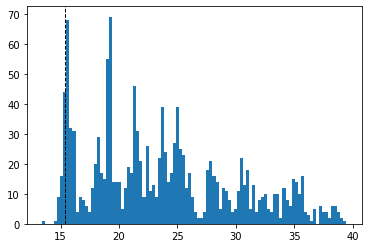

In [37]:
PE_MIN = 0
PE_MAX = 100

def peDistribution(id):
    pe = daily[daily['id']==id][['date','id','name','pe']]
    pe = pe[(pe['pe'] > PE_MIN) & (pe['pe'] < PE_MAX)]
    return pe['pe'].tolist()

id = 1723
pe = peDistribution(id)
y, x, _ = plt.hist(pe, 100)
df_id = out[out['id']==id]
name = df_id['name'].iloc[0]
now_pe = df_id['pe'].iloc[0]
most_pe = round(x[np.where(y == y.max())][0], 2)
eps = df_id['eps'].iloc[0]

print(f"[{len(pe)}]", name)
print('[PE] :', '目前:', now_pe, 'most:', most_pe)
print('[EPS]:','目前:', eps)
plt.axvline(now_pe, color='k', linestyle='dashed', linewidth=1)

plt.show()

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

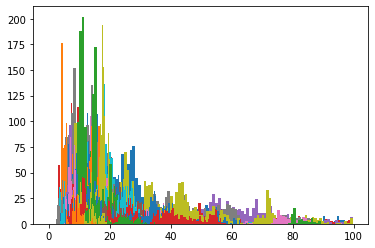

In [38]:
df_target = pd.DataFrame(columns=['count', 'id', 'name', 'now_pe','most_pe', 'avg_pe', 'eps', '收盤價', '偏離平均程度'])

def countTarget(id):
    pe = peDistribution(id)
    y, x, _ = plt.hist(pe, 100)
    df_id = out[out['id']==id]
    name = df_id['name'].iloc[0]
    now_pe = df_id['pe'].iloc[0]
    most_pe = round(x[np.where(y == y.max())][0], 2)
    avg_pe = df_id['avg_pe'].iloc[0]
    eps = df_id['eps'].iloc[0]
    close = df_id['收盤價'].iloc[0]
    cal_pe = min(most_pe, avg_pe)
    

    new_row = {'count': len(pe), 
               'id':id, 
               'name':name, 
               'now_pe':now_pe, 
               'most_pe':most_pe, 
               'avg_pe': avg_pe,
               'eps':eps, 
               '收盤價':close,
               '偏離平均程度':round(100*(cal_pe/now_pe - 1), 2)
              }
    
    df_target.loc[len(df_target)] = new_row
    

[countTarget(id) for id in filter1['id'].tolist()]

In [39]:
id = df_target['id'].isin(filter1['id'].tolist())

df_target_filter = (df_target[(df_target['count'] > 0)]) # 過濾pe數量>0
df_target_filter = df_target_filter.sort_values(by=['偏離平均程度'],ascending=False)
df_target_filter = df_target_filter.reset_index(drop=True)

df_target_filter

,count,id,name,now_pe,most_pe,avg_pe,eps,收盤價,偏離平均程度
0,1378,2303,聯電,6.87,16.78,19.28,6.79,46.65,144.25
1,1120,6670,復盛應用,5.74,11.55,11.68,34.47,198.00,101.22
2,1378,4536,拓凱,6.51,12.85,14.59,25.34,165.00,97.39
3,1378,9802,鈺齊-KY,6.85,12.19,15.45,17.67,121.00,77.96
4,1292,6416,瑞祺電通,13.82,23.98,22.88,6.26,86.50,65.56
5,1364,6271,同欣電,10.55,16.77,19.68,15.21,160.50,58.96
6,1378,2484,希華,7.91,12.08,16.72,4.33,34.25,52.72
7,1378,4977,眾達-KY,10.35,15.79,20.47,8.09,83.70,52.56
8,1378,3665,貿聯-KY,11.80,16.73,17.23,25.29,298.50,41.78
9,1378,5522,遠雄,8.71,13.60,12.28,6.57,57.20,40.99


In [40]:
# 偏離程度>20
bias = df_target_filter['偏離平均程度'] > 20
isLong = df_target_filter['id'].isin(long_ids)
isTorn = df_target_filter['id'].isin(torn_ids)
df_target_filter[bias & isLong].to_csv(f'{today}_long.csv')
df_target_filter[bias & isTorn].to_csv(f'{today}_torn.csv')
df_target_filter[bias].to_csv(f'{today}_filter.csv')
df_target_filter[bias]

,count,id,name,now_pe,most_pe,avg_pe,eps,收盤價,偏離平均程度
0,1378,2303,聯電,6.87,16.78,19.28,6.79,46.65,144.25
1,1120,6670,復盛應用,5.74,11.55,11.68,34.47,198.00,101.22
2,1378,4536,拓凱,6.51,12.85,14.59,25.34,165.00,97.39
3,1378,9802,鈺齊-KY,6.85,12.19,15.45,17.67,121.00,77.96
4,1292,6416,瑞祺電通,13.82,23.98,22.88,6.26,86.50,65.56
5,1364,6271,同欣電,10.55,16.77,19.68,15.21,160.50,58.96
6,1378,2484,希華,7.91,12.08,16.72,4.33,34.25,52.72
7,1378,4977,眾達-KY,10.35,15.79,20.47,8.09,83.70,52.56
8,1378,3665,貿聯-KY,11.80,16.73,17.23,25.29,298.50,41.78
9,1378,5522,遠雄,8.71,13.60,12.28,6.57,57.20,40.99


In [41]:
bias_ids = df_target_filter[bias]['id'].tolist()
df_prob[df_prob['id'].isin(bias_ids)].to_csv(f'{today}_probility.csv', index=False)

# 更新每月filter

In [47]:
# 需更新local的filter.csv檔案,再依據檔案新增新的
old = pd.read_csv('filter.csv') # 20230801
new = pd.merge(old, df_target_filter[bias][['id','name','收盤價']], how='outer')
new.rename(columns = {'收盤價': today}, inplace = True)
print(len(old), len(new))
new.to_csv(f"filter.csv", index = False)
new

352 352


,id,name,202207,202208,202209,202210,202211,20221128,20221213,202301,202302,202303,202304,20230502,20230524,20230615,20230711,20230724,20230801
0,1104,環泥,22.30,21.65,NaN,20.30,20.85,21.80,22.75,23.25,23.60,25.55,26.75,28.75,27.85,31.25,29.90,NaN,NaN
1,1108,幸福,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,14.10,16.10,16.50,15.35,16.30,16.55,NaN,NaN
2,1203,味王,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,38.20,38.30,NaN,41.60,NaN,NaN,NaN,NaN
3,1307,三芳,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,20.80,21.20,21.15,21.00,23.80,NaN,NaN,NaN,NaN
4,1319,東陽,NaN,NaN,NaN,NaN,NaN,45.60,47.35,43.10,43.60,46.80,47.80,48.55,51.10,54.20,51.40,51.90,NaN
5,1342,八貫,NaN,NaN,82.50,76.30,80.20,87.60,NaN,NaN,NaN,NaN,NaN,146.50,131.00,NaN,NaN,115.00,NaN
6,1434,福懋,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,27.85,28.30,28.35,NaN,NaN,NaN,NaN,NaN
7,1444,力麗,NaN,NaN,11.75,NaN,10.40,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,1476,儒鴻,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,496.50,470.50,494.00,487.50,NaN,NaN,NaN,NaN,NaN
9,1477,聚陽,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,221.50,232.50,223.50,225.50,227.50,NaN,NaN,NaN,NaN


In [42]:
db.close()